In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
import pandas as pd
import numpy as np
import sys

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=sys.maxsize)

### Variable names are refering to the notebooks in this project.

In [4]:
api_df = pd.read_csv(project.get_file('spacex_api_copy.csv'))

scrape_df = pd.read_csv(project.get_file('spacex_web_scraped.csv'))

wrangle_df = pd.read_csv(project.get_file('data_wrangling.csv'))

feature_df = pd.read_csv(project.get_file('pre_data_feature.csv'))

folium_df = pd.read_csv(project.get_file('sites_folium.csv'))

dash_df = pd.read_csv(project.get_file('spacex_launch_dash.csv'))

- Capstone datasets are inconsistent. I'm not sure this was done by design, but half of the samples provided for the Dash App and Folium were missing. It looks like the last time spacex api notebook was updated in September of 2020. I've added the missing launches into the project.   


- It looks like launch site CCAFS LC-40 was last used in  August 14 2016 due to an accident in Sepetember of the same year. It's now called CCAFS SLC-40. <a href='https://en.wikipedia.org/wiki/Cape_Canaveral_Space_Launch_Complex_40#:~:text=Space%20Launch%20Complex%2040%5B2%5D%5B3%5D%20(SLC%2D40)%2C%20previously%20Launch%20Complex%2040%20(LC%2D40)%20is%20a%20launch%20pad%20for%20rockets%20located%20at%20the%20north%20end%20of%20Cape%20Canaveral%20Space%20Force%20Station%2C%20Florida.'>CCAFS LC-40 Wiki Link</a>  
    
    
- Officially, SpaceX uses 4 launch Sites. CCAFS SLC-40, KSC LC-39A, VAFB SLC-4E, and Starbase in Boca Chica-TX. We will be ignoring the Starbese Site since it's not used for Falcon 9 launches. <a href='https://en.wikipedia.org/wiki/SpaceX_Starbase#:~:text=The%20launch%20site,launch%20vehicle%2C%20Starship'>Starbase Wiki Link</a>  
    
    
- CCAFS Launch site was renamed CCSFS in December 2020. <a href='https://en.wikipedia.org/wiki/Cape_Canaveral_Space_Force_Station#:~:text=Cape%20Canaveral%20was,pandemic.%5B10%5D%5B11%5D'> CCSFS Wiki Link </a>

In [34]:
print(api_df.shape)
api_df.head()

(132, 20)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,PayloadName,Customer,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,Serial,ReusedCount,LaunchSite,Longitude,Latitude,Block_Version
0,1,2010-06-04,Falcon 9,7407.0,LEO,Dragon Qualification Unit,SpaceX,None None,1,False,False,False,NaN,1.0,B0003,0,CCSFS SLC 40,-80.577366,28.561857,v1.0
1,2,2012-05-22,Falcon 9,525.0,LEO,COTS Demo Flight 2,NASA(COTS),None None,1,False,False,False,NaN,1.0,B0005,0,CCSFS SLC 40,-80.577366,28.561857,v1.0
2,3,2013-03-01,Falcon 9,677.0,ISS,CRS-2,NASA (CRS),None None,1,False,False,False,NaN,1.0,B0007,0,CCSFS SLC 40,-80.577366,28.561857,v1.0
3,4,2013-09-29,Falcon 9,500.0,PO,CASSIOPE,MDA,False Ocean,1,False,False,False,NaN,1.0,B1003,0,VAFB SLC 4E,-120.610829,34.632093,v1.0
4,5,2013-12-03,Falcon 9,3170.0,GTO,SES-8,SES,None None,1,False,False,False,NaN,1.0,B1004,0,CCSFS SLC 40,-80.577366,28.561857,v1.0


In [35]:
api_df['Date'] = pd.to_datetime(api_df['Date'])

In [36]:
spacex_df = api_df.copy()

In [37]:
import time
first_ground_land = spacex_df[spacex_df['Outcome'] == 'True RTLS'].min()['Date']
f"The first ground landing date was in {first_ground_land.strftime('%B, %d, %Y')}"

'The first ground landing date was in December, 22, 2015'

In [38]:
true_asds = spacex_df[spacex_df['Outcome'] == 'True ASDS']
asds_payload_range = true_asds[true_asds['PayloadMass'].between(4000,6000)]
asds_payload_range

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,PayloadName,Customer,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,Serial,ReusedCount,LaunchSite,Longitude,Latitude,Block_Version
20,21,2016-05-06,Falcon 9,4696.0,GTO,JCSAT-2B,SKY Perfect JSAT Group,True ASDS,1,True,False,True,OCISLY,2.0,B1022,0,CCSFS SLC 40,-80.577366,28.561857,v1.1
23,24,2016-08-14,Falcon 9,4600.0,GTO,JCSAT-16,SKY Perfect JCSAT Group,True ASDS,1,True,False,True,OCISLY,2.0,B1026,0,CCSFS SLC 40,-80.577366,28.561857,v1.1
28,29,2017-03-30,Falcon 9,5300.0,GTO,SES-10,SES,True ASDS,2,True,True,True,OCISLY,2.0,B1021,1,KSC LC 39A,-80.603956,28.608058,v1.1
39,40,2017-10-11,Falcon 9,5200.0,GTO,SES-11 / Echostar 105,SES,True ASDS,2,True,True,True,OCISLY,3.0,B1031,1,KSC LC 39A,-80.603956,28.608058,FT
54,55,2018-08-07,Falcon 9,5800.0,GTO,Telkom-4,Telkom,True ASDS,2,True,True,True,OCISLY,5.0,B1046,3,CCSFS SLC 40,-80.577366,28.561857,B5
58,59,2018-12-03,Falcon 9,4000.0,SSO,SSO-A,"Spaceflight Industries, Inc",True ASDS,3,True,True,True,JRTI,5.0,B1046,3,VAFB SLC 4E,-120.610829,34.632093,B5
69,70,2019-12-05,Falcon 9,5000.0,ISS,CRS-19,NASA (CRS),True ASDS,1,True,False,True,OCISLY,5.0,B1059,5,CCSFS SLC 40,-80.577366,28.561857,B5


In [39]:
outcome_col = spacex_df[['Outcome']]
outcome_col.count()

Outcome    132
dtype: int64

In [40]:
max_payload = spacex_df['PayloadMass'].max()
max_payload_idx = spacex_df.loc[spacex_df['PayloadMass'].idxmax()]
booster = max_payload_idx['BoosterVersion']
print(f'The {booster} booster carried the heaviest payload with a total of {max_payload} Kilograms')

The Falcon 9 booster carried the heaviest payload with a total of 15600.0 Kilograms


In [41]:
count = spacex_df['Outcome'].str.contains('True').value_counts()
print(f'SpaceX had a total of {count.values[0]} successful missions, and a total of {count.values[1]} failed missions.')

SpaceX had a total of 101 successful missions, and a total of 31 failed missions.


In [42]:
import datetime as dt
spacex_df['Date'] = pd.to_datetime(spacex_df['Date'])
launches_2015 = spacex_df[spacex_df['Date'].dt.year == 2015]

In [43]:
false_asds = launches_2015[launches_2015['Outcome'] == 'False ASDS']
filtered_false_asds = false_asds[['Outcome', 'BoosterVersion', 'LaunchSite', 'Date' ]]
filtered_false_asds

,Outcome,BoosterVersion,LaunchSite,Date
11,False ASDS,Falcon 9,CCSFS SLC 40,2015-01-10
13,False ASDS,Falcon 9,CCSFS SLC 40,2015-04-14


In [44]:
date_2010_2017 = spacex_df[(spacex_df['Date'] >= '2010-06-04') & (spacex_df['Date'] <= '2017-03-20')]
outcome_value_count = date_2010_2017['Outcome'].value_counts().sort_values(ascending=False)

x = 0
for i in outcome_value_count.iteritems():
    x = x + 1
    if x < 2:
        print(f'{x}st landing outcome is "{i[0]}" with "{i[1]}" outcomes')
    elif x < 3:
        print(f'{x}nd landing outcome is "{i[0]}" with "{i[1]}"  outcomes')
    elif x < 4:
        print(f'{x}rd landing outcome is "{i[0]}" with "{i[1]}"  outcomes')
    else:
        print(f'{x}th landing outcome is "{i[0]}" with "{i[1]}"  outcomes')

1st landing outcome is "None None" with "9" outcomes
2nd landing outcome is "True ASDS" with "5"  outcomes
3rd landing outcome is "False ASDS" with "4"  outcomes
4th landing outcome is "True Ocean" with "3"  outcomes
5th landing outcome is "True RTLS" with "3"  outcomes
6th landing outcome is "False Ocean" with "2"  outcomes
7th landing outcome is "None ASDS" with "2"  outcomes


In [46]:
class_label_1 = spacex_df[spacex_df['Class'] == 1]
launch_count = class_label_1.groupby(['LaunchSite'])['Class'].value_counts().unstack().reset_index()
launch_count.columns = ['LaunchSite', 'Class_1']
launch_count

,LaunchSite,Class_1
0,CCSFS SLC 40,52
1,KSC LC 39A,34
2,VAFB SLC 4E,15


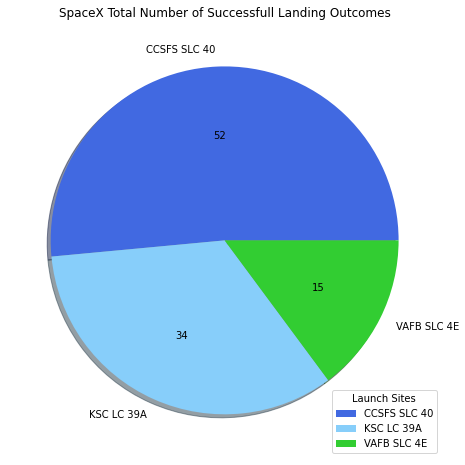

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(launch_count['Class_1'], labels=launch_count['LaunchSite'], shadow=True, autopct=lambda p: '{:.0f}'.format(p*(launch_count['Class_1'].sum())/100), colors=['royalblue','lightskyblue','limegreen'])
ax.legend(launch_count['LaunchSite'], title='Launch Sites')
ax.set_title('SpaceX Total Number of Successfull Landing Outcomes')
plt.show()

In [48]:
outcome_ratio = spacex_df.groupby('LaunchSite')['Class'].value_counts(normalize=True).unstack().reset_index()
outcome_ratio.columns = ['LaunchSite', 'Class_0', 'Class_1']
outcome_ratio

,LaunchSite,Class_0,Class_1
0,CCSFS SLC 40,0.306667,0.693333
1,KSC LC 39A,0.128205,0.871795
2,VAFB SLC 4E,0.166667,0.833333


In [49]:
outcome_ratio[outcome_ratio['Class_1'] == outcome_ratio['Class_1'].max()]

,LaunchSite,Class_0,Class_1
1,KSC LC 39A,0.128205,0.871795


In [50]:
best_site = spacex_df[spacex_df['LaunchSite'] == 'KSC LC 39A']
best_site = best_site.groupby('LaunchSite')['Class'].value_counts(normalize=True).reset_index(name='Count')
best_site

,LaunchSite,Class,Count
0,KSC LC 39A,1,0.871795
1,KSC LC 39A,0,0.128205


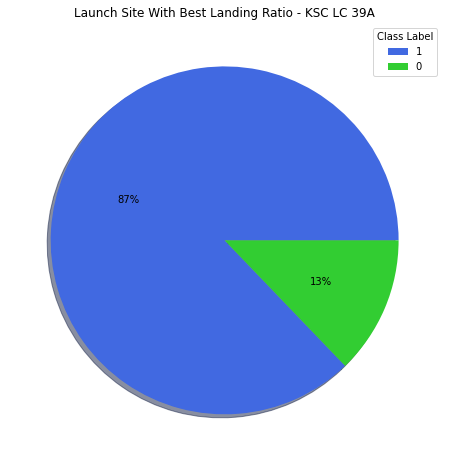

In [51]:
fig1, ax1 = plt.subplots(figsize=(8,8))
wedge = ax1.pie(best_site['Count'], autopct='%1.0f%%', shadow=True, colors=['royalblue','limegreen'])
ax1.legend(best_site['Class'], title='Class Label')
ax1.set_title('Launch Site With Best Landing Ratio - KSC LC 39A')
plt.show()

In [56]:
nasa_df = spacex_df.loc[spacex_df['Customer'].str.contains('NASA')]
nasa_payload = nasa_df['PayloadMass'].sum()
print(f'SpaceX launched into space a total payload of {nasa_payload} Kilograms on behalf of Nasa')

SpaceX launched into space a total payload of 129170.7 Kilograms on behalf of Nasa


In [57]:
v1_df = spacex_df.loc[spacex_df['Block_Version'].str.contains('v1.1')]
v1_payload_df = v1_df['PayloadMass'].mean().round(decimals=2)
print(f'SpaceX launched into space an average of {v1_payload_df} Kilograms per payload using the F9 v1.1 Booster')

SpaceX launched into space an average of 3848.17 Kilograms per payload using the F9 v1.1 Booster


In [59]:
class_1_label = spacex_df[spacex_df['Class'] == 1]
launch_site = class_1_label[['LaunchSite', 'Class']]
launch_site

,LaunchSite,Class
6,CCSFS SLC 40,1
7,CCSFS SLC 40,1
12,CCSFS SLC 40,1
16,CCSFS SLC 40,1
19,CCSFS SLC 40,1
20,CCSFS SLC 40,1
21,CCSFS SLC 40,1
22,CCSFS SLC 40,1
23,CCSFS SLC 40,1
25,VAFB SLC 4E,1


In [18]:
dash_df = wrangle_df[['FlightNumber', 'LaunchSite', 'Outcome', 'Class', 'PayloadMass', 'BoosterVersion', 'Block_Version']]
print(dash_df.shape)
dash_df.head()

(132, 7)


,FlightNumber,LaunchSite,Outcome,Class,PayloadMass,BoosterVersion,Block_Version
0,1,CCSFS SLC 40,None None,0,7407.0,Falcon 9,v1.0
1,2,CCSFS SLC 40,None None,0,525.0,Falcon 9,v1.0
2,3,CCSFS SLC 40,None None,0,677.0,Falcon 9,v1.0
3,4,VAFB SLC 4E,False Ocean,0,500.0,Falcon 9,v1.0
4,5,CCSFS SLC 40,None None,0,3170.0,Falcon 9,v1.0


In [23]:
project.save_data(data=dash_df.to_csv(index=False), file_name='spacex_launch_dash.csv', overwrite=True)

{'file_name': 'spacex_launch_dash.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-jx5un88ldtszdu',
 'asset_id': 'bc9827fb-e1c2-45e4-a016-9377d574995b'}

In [60]:
project.save_data(data=api_df.to_csv(index=False), file_name='spacex_api.csv', overwrite=True)

{'file_name': 'spacex_api.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-jx5un88ldtszdu',
 'asset_id': 'e3d9174d-7142-4ae0-a172-c58e7c0fbe08'}